<h1>UI to Semantic Hierarchie</h1>

<p style="font-size:12pt">In this notebook we create a machine learning model with the deep learning API <a href="https://www.tensorflow.org/guide/keras"> Keras </a>. This machine learning model should be able to translate a given UI image into a hierarchie with semantic annotations specified on the homepage of the <a href="http://interactionmining.org/rico">Rico</a> dataset. We create our model similar to the Work of Chunyang Chen, Ting Su, Guozhu Meng, Zhenchang Xing, and Yang Liu. 2018. <a href="https://chunyang-chen.github.io/publication/ui2code.pdf">From UI Design Image to GUI Skeleton: A Neural Machine Translator to Bootstrap Mobile GUI Implementation</a>. </p>

 ## Import packages
 ### Dependencies
- tensorflow
- numpy
- matplotlib
- sklearn

In [1]:
import tensorflow as tf
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import math
import pickle

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Reshape, Dense, Embedding
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

## Load data (and optional: limit the size )
We will use the <a href="http://interactionmining.org/rico">Rico</a> Dataset containing visual, textual, structural, and interactive design properties of more than 66k unique UI screens. But for this task we only use the UI screenshots and a modified version of the UI hierarchies with semantic annotations. To speed up training you are free to use only a limited amount of UI images. <br>

### Project tree

 * [Project Folder](./Project Folder)
   * [semantic_annotations](./Project Folder/semantic_annotations) 
     * [0.json]
     * [0.png]
     ...
   * [unique_uis](./Project Folder/unique_uis)
     * [0.json]
     * [0.jpg]
     ...
   * [notebookname.ipynb](./Project Folder/notebookname.ipynb)

In [3]:
# Path to the UI screenshots
uiImageFolder = "/unique_uis/"
PathUIImages = os.path.abspath('.') + uiImageFolder

# Path to the semantic annotations
semanticAnnotations = "/semantic_annotations/"
PathSemanticAnnotations = os.path.abspath('.') + semanticAnnotations

# total amount of images and hierarchies
totalAmount = 72218
# Select the first 1500 UI images
numExamples = 1500

# Store UI screenshots and hierarchies with semantic annotations
allUIs = []
allSemanticAnnotations = []

for x in range(min(numExamples, totalAmount)):
    uiImagePath = PathUIImages + "{}.jpg".format(x)
    semanticAnnotationPath = PathSemanticAnnotations + "{}.json".format(x)
    
    # check if both Paths exist if not dont add them
    if os.path.exists(uiImagePath) and os.path.exists(semanticAnnotationPath):
        allUIs.append(uiImagePath)
        allSemanticAnnotations.append(semanticAnnotationPath)

## Get the component hierarchies
Now we just got the Paths to the UIs and the Paths to the hierarchies with semantic annotations as json. But we want the component hierarchie as a String. So we need to traverse the json objects to extract the component labels and if available the specific Class of an Icon or the the Text Button Class.

In [4]:
# filter the UI components from an "AST"(the hierarchies with semantic annotations as json) into Code with DFT 
# example: "<start>WebView,Advertisement{WebView{WebView}}<end>"
uiComponentHierarchies = []

# depth first traversal for json objects which extracts all component labels without whitespaces 
# and seperates each component with " "(also ",", "{" and "}" are components) to better split the components
def dft(jsonTree, components):
    jsonTreeLen = len(jsonTree)-1
    for index, child in enumerate(jsonTree):
        if "iconClass" in child:
            components +=  "Icon(" + child["iconClass"].replace(" ", "") + ")"
        elif "textButtonClass" in child:
            components += "TextButton(" + child["textButtonClass"].replace(" ", "") + ")"
        else:
            components += child["componentLabel"].replace(" ", "")
            
        if "children" in child:
            components += " { " + dft(child["children"], "") + " } "            
            
        if len(jsonTree) > 1 and index < jsonTreeLen:
            components +=  " , "
       
    return components

# use dft on every json object in our path list to get the component hierarchie 
for semanAnnot in allSemanticAnnotations:

    # read the json file
    with open(semanAnnot, "r", encoding="utf-8") as f:
        AST = json.load(f)["children"]

    # construct the UI Component hierarchie
    uiCompHierarchie = "<start> " + dft(AST, "") + " <end>"

    uiComponentHierarchies.append( uiCompHierarchie)


In [5]:
len(allUIs), len(uiComponentHierarchies)

(1430, 1430)

## Understand the data
To get more failiar with the data, here you see 3 examples of UI screenshots and the Component hierarchie and also with a picture visualizing the components and the Icons or TextButtons also sometimes belong to Classes like Icon(settings).

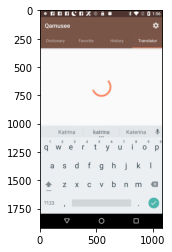

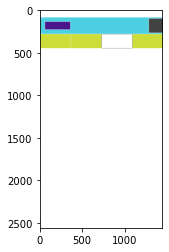

<start> Toolbar { Text , Icon(settings) }  , TextButton , TextButton , TextButton(history) , TextButton <end>


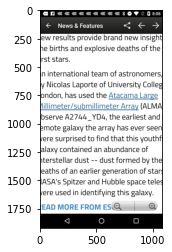

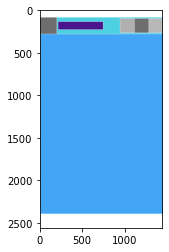

<start> Toolbar { Text , Icon(arrow_backward) , Icon(share) , Icon(arrow_backward) , Icon(arrow_forward) }  , WebView <end>


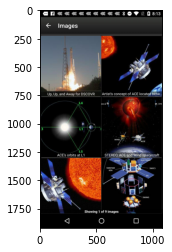

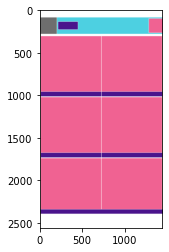

<start> Text , Toolbar { Text , Icon(arrow_backward) , Image }  , ListItem { Image , Text }  , ListItem { Image , Text }  , ListItem { Image , Text }  , ListItem { Image , Text }  , ListItem { Image }  , ListItem { Image }  <end>


In [6]:
def show_image(index):
    img = mpimg.imread(allUIs[index])
    imgplot = plt.imshow(img)
    plt.show()
    img = mpimg.imread("./semantic_annotations/{}.png".format(index))
    imgplot = plt.imshow(img)
    plt.show()
    print(uiComponentHierarchies[index])

show_image(42)
show_image(69)
show_image(80)

For convenience declare some variables we use.

In [7]:
batch_size = 32
epochs = 10
IMG_HEIGHT = 224
IMG_WIDTH = 224

## Pre-trained CNN (VGG16)

We use the VGG16 model using the Keras API for our feature extraction by vision. This automatically downloads the required files if you don't have them already.
This model was pretrained for classifiying images and has a convolutional part and a fully connected part. But we only use the convolutional part because we just want the resulting feature vectors.

First we write a helper function that loads and preprocesses images:

In [8]:
def load_image(path, size=None):
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img, dtype="float32")

    # Perform any preprocessing needed by InceptionV3 or others
    img = tf.keras.applications.vgg16.preprocess_input(img)

    return img

In [9]:
image_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
image_model.trainable = False

In [10]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Show the layers of the model:

In [11]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

In [12]:
cnn_output_size = K.int_shape(image_model.output)[1:4]
cnn_output_size

(7, 7, 512)

# Creating the dataset

## Preprocess the images
First we need to run all images through the CNN to encode these. The resulting feature map's of those will be used for training to create the hierarchie from the features of the images extracted from the VGG16 model.

In [13]:
def encode_img(img_path):
    # load the image
    img = load_image(img_path, img_size)
    img = np.expand_dims(img, axis=0)
    # Get the feature map for the image
    img = image_model.predict(img)
    return img[0]

In [14]:
filename = "encodedImages"
if not os.path.exists(filename):
    encoding_img = []
    for img_path in allUIs:
        encoding_img.append(encode_img(img_path)) 
    with open(filename, "wb") as fp:
        pickle.dump(encoding_img, fp)
else:
    with open(filename, "rb") as fp:
        encoding_img = pickle.load(fp)

## Tokenize the component hierarchies

Because neural networks cannot process textual data we need to transform the component hierarchies. We need to convert text-words into so-called integer-tokens.

In [15]:
tokenizer = Tokenizer(filters="", lower=False)
tokenizer.fit_on_texts(uiComponentHierarchies)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
tokenizer.word_index

{',': 1,
 'Text': 2,
 '{': 3,
 '}': 4,
 'Image': 5,
 'ListItem': 6,
 'TextButton': 7,
 '<start>': 8,
 '<end>': 9,
 'Toolbar': 10,
 'WebView': 11,
 'Input': 12,
 'Icon(arrow_backward)': 13,
 'Advertisement': 14,
 'Icon(more)': 15,
 'Icon(menu)': 16,
 'Icon(avatar)': 17,
 'Card': 18,
 'Icon(add)': 19,
 'Icon(arrow_forward)': 20,
 'Icon(search)': 21,
 'Drawer': 22,
 'BackgroundImage': 23,
 'Icon(play)': 24,
 'Icon(close)': 25,
 'Icon(chat)': 26,
 'RadioButton': 27,
 'Checkbox': 28,
 'Icon(star)': 29,
 'Modal': 30,
 'Multi-Tab': 31,
 'Icon(share)': 32,
 'PagerIndicator': 33,
 'Icon(info)': 34,
 'Icon(expand_more)': 35,
 'TextButton(login)': 36,
 'Icon(settings)': 37,
 'Icon(favorite)': 38,
 'Icon(check)': 39,
 'Icon(home)': 40,
 'Icon(facebook)': 41,
 'On/OffSwitch': 42,
 'Icon(date_range)': 43,
 'Icon(emoji)': 44,
 'Icon(help)': 45,
 'Icon(refresh)': 46,
 'Slider': 47,
 'Icon(lock)': 48,
 'Icon(sliders)': 49,
 'TextButton(create)': 50,
 'Icon(thumbs_up)': 51,
 'Icon(time)': 52,
 'Icon(thu

In [16]:
vocab_size = len(tokenizer.word_index)
vocab_size

255

In [17]:
# Create tokenized vectors
token_hierarchies = tokenizer.texts_to_sequences(uiComponentHierarchies)

In [18]:
# Find the maximum length of any hierarchie in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [19]:
max_length = calc_max_length(token_hierarchies)
max_length

244

Create dictionary with image Paths and corresponding token hierarchies.

In [20]:
# Create training and validation sets using an 80-20 split
fm_train, fm_val, hier_train, hier_val = train_test_split(encoding_img, token_hierarchies, test_size=0.2, random_state=0)

dataset_train = list(zip(fm_train, hier_train))
dataset_val = list(zip(fm_val, hier_val))

In [57]:
print("Length Training dataset")
print(len(fm_train))
print("Length Validation dataset")
print(len(fm_val))

Length Training dataset
1144
Length Validation dataset
286


## Data Generator
Because we train our model to generate the next token given a sequence and a feature map of an image, we normally would need to save the feature map of an image for each timestep the hierarchie is in. This would need a lot more space which can be avoided by using a so called data generator. The data generator can then be used to construct our dataset in batches so we dont need to fit the whole dataset with multiple hierarchies per image into memory at once.

In [21]:
def data_generator(dataset, batch_size=batch_size, dim=img_size, n_channels=3,
                 n_classes=vocab_size):
    # x1 - Image batch
    # x2 - The hierarchie
    # y - The predicted hierarchie
    x1, x2, y = [], [], []
    n=0
    while True:
        for feature_map, hierarchie in dataset:
            for i in range(1, len(hierarchie)):
                n+=1
                in_hier, out_hier = hierarchie[:i], hierarchie[i]
                in_hier = tf.keras.preprocessing.sequence.pad_sequences([in_hier], maxlen=max_length, padding='post')[0]
                out_hier = tf.keras.utils.to_categorical([out_hier], num_classes=vocab_size)[0]
                x1.append(feature_map)
                x2.append(in_hier)
                y.append(out_hier)
                if n==batch_size:
                    yield ([np.array(x1), np.array(x2)], np.array(y))
                    x1, x2, y = [], [], []
                    n=0

In [22]:
training_generator = data_generator(dataset_train)
validation_generator = data_generator(dataset_val)

In [23]:
steps_train = (len(dataset_train) * max_length) // batch_size
steps_train

8723

In [24]:
steps_val = (len(dataset_val) * max_length) // batch_size
steps_val

2180

The training data has the form:

In [25]:
data = []     # store all the generated data batches
labels = []   # store all the generated label batches
max_iter = 1  # maximum number of iterations, in each iteration one batch is generated; the proper value depends on batch size and size of whole data
i = 0
for d, l in training_generator:
    data.append(d)
    labels.append(l)
    i += 1
    if i == max_iter:
        break

In [26]:
print("Generator model input:")
print("image input")
print(data[0][0][0])
print("decoder input")
print(data[0][1][0])
print("------------------")
print("Generator model output:")
print(labels[0][0])

Generator model input:
image input
[[[0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  ...
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]]

 [[0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  ...
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.       ]]

 [[0.        0.        0.        ... 0.        0.        0.       ]
  [0.        0.        0.        ... 0.        0.        0.      

## Create the Recurrent Neural Network
We will now create the Model with LSTMs which will be trained to map the feature vectors from the image recognition model and the sequence computed so far into a probability distribution over the vocabulary to get a prediction for the next token in the hierarchie. 

The encoder and decoder consists of an LSTM whose internal state size is:

In [27]:
state_size = 256

feature_vector_length =  cnn_output_size[2]
number_feature_vectors = cnn_output_size[0] * cnn_output_size[1]

### Encoder:

In [28]:
# Expect as input a feature map from the last pooling layer of our CNN the VGG16 model
encoder_input = Input(shape=cnn_output_size)
# transform the feature map from the feature extraction cnn into an array of feature vectors for the LSTM
encoder_input_cnn = Reshape((number_feature_vectors, feature_vector_length))
encoder_outputs = encoder_input_cnn(encoder_input)

encoder = LSTM(state_size, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_outputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

### Decoder

In [29]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
# This is the embedding layer which converts sequences of integer-tokens to sequences of vectors.
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=128)
embedd_outputs = decoder_embedding(decoder_inputs)
decoder_lstm = LSTM(state_size, input_shape=(vocab_size,))
decoder_outputs = decoder_lstm(embedd_outputs,
                                     initial_state=encoder_states)
#convert LSTM output with shape [batch_size, state_size] into sequence of tokens
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

## Model

In [30]:
# Define the model that will turn
# `image_model inputs` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_input, decoder_inputs], decoder_outputs)

### Compile the Model
The output of the decoder is a one-hot encoded vector. In order to train the decoder we need to supply the one-hot encoded vector that we desire to see on the decoder's output at each step, and then use a loss-function like cross-entropy to train the decoder to produce this desired output.

In [31]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 7, 7, 512)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 49, 512)      0           input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    32640       input_3[0][0]                    
_______________________________________________________________________________________

## Callback Function
During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

In [33]:
path_checkpoint = 'UI_image2SemanticHierarchie_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint)


# callback for TensorBoard
callback_tensorboard = TensorBoard(log_dir='./UI_image2SemanticHierarchie_logs/')


callbacks = [callback_checkpoint, callback_tensorboard]

## Load Checkpoint

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

### Train the model

In [34]:
# Run training
model.fit(training_generator, 
          epochs=epochs,
          steps_per_epoch = steps_train,
          validation_data = validation_generator,
          validation_steps = steps_val,
          callbacks=callbacks)

Epoch 1/10
   1/8723 [..............................] - ETA: 0s - loss: 5.5432 - accuracy: 0.0000e+00WARNING:tensorflow:From c:\users\eendr\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
8723/8723 [==============================] - 7174s 822ms/step - loss: 2.4949 - accuracy: 0.3464 - val_loss: 2.5010 - val_accuracy: 0.3498
Epoch 2/10
8723/8723 [==============================] - 7137s 818ms/step - loss: 1.9845 - accuracy: 0.4803 - val_loss: 1.7747 - val_accuracy: 0.5839
Epoch 3/10
8723/8723 [==============================] - 7164s 821ms/step - loss: 1.3601 - accuracy: 0.6679 - val_loss: 1.3689 - val_accuracy: 0.6838
Epoch 4/10
8723/8723 [==============================] - 7129s 817ms/step - loss: 1.2104 - accuracy: 0.7089 - val_loss: 1.2854 - val_accuracy: 0.7179
Epo

## Generate Component Hierarchie and Evaluate the Model
This Function generates the component hierarchie of an UI image with the trained model.

In [35]:
token_start = tokenizer.word_index["<start>"]
token_end = tokenizer.word_index["<end>"]

In [40]:
def generateSemanticHierarchie(image_path):
    feature_map = encode_img(image_path)
    feature_map = np.expand_dims(feature_map, axis=0)
    in_hierarchie = "<start>"
    for i in range(max_length):
        sequence = [tokenizer.word_index[t] for t in in_hierarchie.split()]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_length, padding='post')
        token_int = model.predict([feature_map,sequence])[0]
        token_int = np.argmax(token_int)
        word = tokenizer.index_word[token_int]
        in_hierarchie += ' ' + word
        if word == "<end>":
            break
    final = in_hierarchie.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


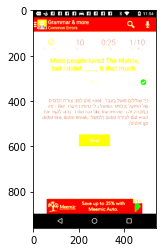

Predicted hierarchie:
Toolbar { Icon(avatar) , Icon(menu) , Image , Text } , Multi-Tab { TextButton , TextButton , TextButton , TextButton , TextButton , TextButton , TextButton } , ListItem { TextButton , TextButton , TextButton , TextButton , TextButton , TextButton , TextButton } , ListItem { TextButton , TextButton , TextButton , TextButton , TextButton , TextButton , TextButton } , ListItem { TextButton , TextButton , TextButton , TextButton , TextButton , TextButton , TextButton } , ListItem { TextButton , TextButton , TextButton , TextButton , TextButton , TextButton , TextButton } , ListItem { TextButton , TextButton , TextButton , TextButton , TextButton , TextButton , TextButton } , ListItem { TextButton , TextButton , TextButton , TextButton , TextButton , TextButton , TextButton }


Original Hierarchie:
Toolbar { Icon(microphone) , Icon(menu) , Image , Text , Text , Image }  , Advertisement { WebView { WebView }  }  , TextButton , Text , TextButton(next) , Text , Text , Tex

In [76]:
imageId = 22234
uiImageFolder = "/unique_uis/"
pathImage = os.path.abspath('.') + uiImageFolder + "{}.jpg".format(imageId)
semanticAnnotations = "/semantic_annotations/"
PathSemanticAnnotations = os.path.abspath('.') + semanticAnnotations + "{}.json".format(imageId)
    
if os.path.exists(pathImage) and os.path.exists(PathSemanticAnnotations):
    image = load_image(pathImage)
    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # read the json file
    with open(PathSemanticAnnotations, "r", encoding="utf-8") as f:
        AST = json.load(f)["children"]
    # construct the UI Component hierarchie
    uiCompHierarchie =  dft(AST, "")
    
    # Print the predicted hierarchie.
    print("Predicted hierarchie:")
    print(generateSemanticHierarchie(pathImage))
    print("\n")
    # Print the original hierarchie
    print("Original Hierarchie:")
    print(uiCompHierarchie)

## Analyse Model with Tensorboard 

In [47]:
%load_ext tensorboard

In [49]:
%tensorboard --logdir UI_image2SemanticHierarchie_logs

Reusing TensorBoard on port 6006 (pid 3848), started 0:00:55 ago. (Use '!kill 3848' to kill it.)